Начало расширенного поиска параметров...
Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


g:\TMM\Repo\TMO\EXAM\venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4800 fits failed out of a total of 9600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4800 fits failed with the following error:
Traceback (most recent call last):
  File "g:\TMM\Repo\TMO\EXAM\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "g:\TMM\Repo\TMO\EXAM\venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "g:\TMM\Repo\TMO\EXAM\venv\lib\site-packages\sklearn\compose\_target.py", line 293, in fit
    self.regressor_.fit(X, y_trans, **routed_params.regressor.

Поиск завершен!

Лучшие параметры:
- regressor__cluster__add_distances: True
- regressor__cluster__method: kmeans
- regressor__cluster__n_clusters: 6
- regressor__features__poly__degree: 2
- regressor__features__poly__interaction_only: True
- regressor__regressor: Ridge()
- regressor__regressor__alpha: 6.951927961775605

Усредненная максимальная ошибка: 0.207063

✅ Модель удовлетворяет условию задачи!

Максимальная ошибка на одном наблюдении: 0.220599
Проблемное наблюдение 91:
- Признаки: [0.20987468 0.50914159 0.45984095]
- Реальное значение: 0.498946
- Предсказанное значение: 0.278347


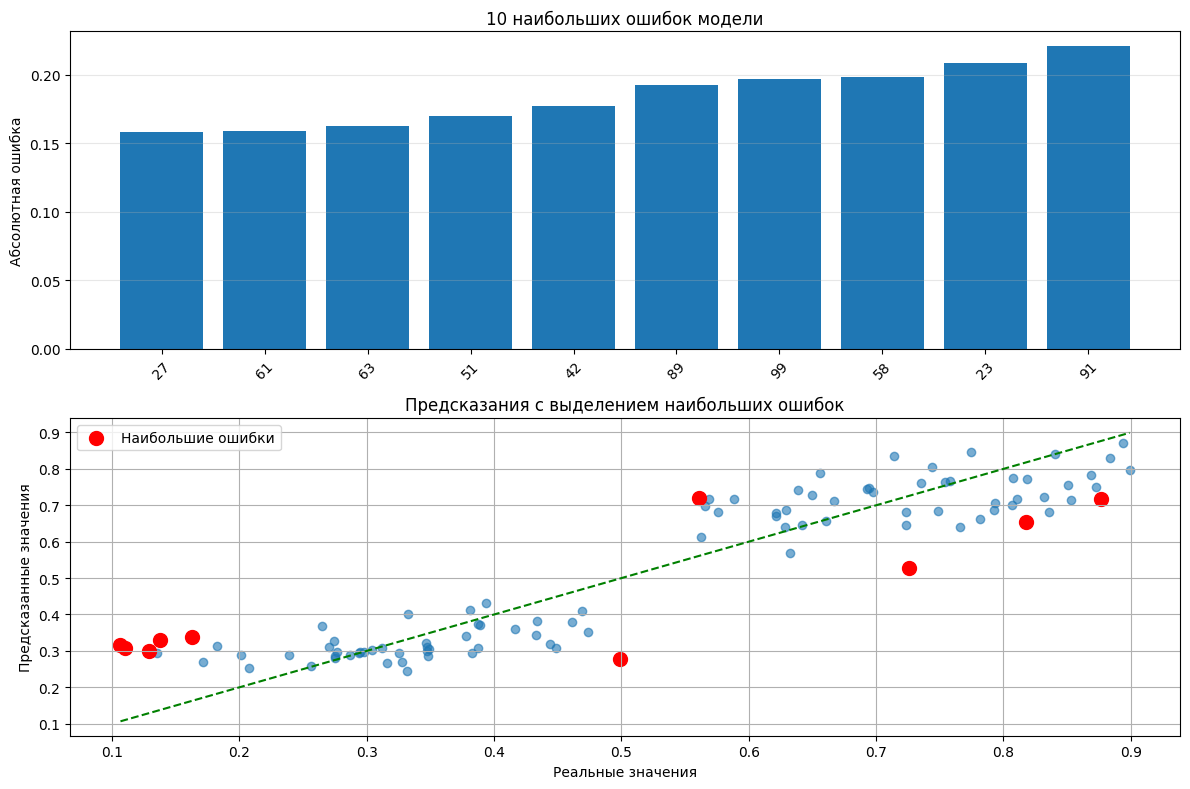

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import max_error
from sklearn.decomposition import PCA
import joblib

# Кастомные трансформеры
class ClusterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, method='kmeans', add_distances=True):
        self.n_clusters = n_clusters
        self.method = method
        self.add_distances = add_distances
        self.model = None
        
    def fit(self, X, y=None):
        if self.method == 'kmeans':
            self.model = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=20)
        elif self.method == 'spectral':
            self.model = SpectralClustering(n_clusters=self.n_clusters, random_state=42)
        elif self.method == 'dbscan':
            self.model = DBSCAN(eps=0.5, min_samples=5)
        else:
            raise ValueError(f"Unknown clustering method: {self.method}")
            
        self.model.fit(X)
        return self
    
    def transform(self, X, y=None):
        if self.method == 'dbscan':
            clusters = self.model.fit_predict(X)
        else:
            clusters = self.model.predict(X)
            
        clusters = clusters.reshape(-1, 1)
        result = np.hstack([X, clusters])
        
        if self.add_distances and hasattr(self.model, 'cluster_centers_'):
            distances = self.model.transform(X)
            result = np.hstack([result, distances])
        
        return result

class InteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        interactions = []
        n_features = X.shape[1]
        
        # Создание взаимодействий признаков
        for i in range(n_features):
            for j in range(i+1, n_features):
                interactions.append(X[:, i] * X[:, j])
        
        if interactions:
            interactions = np.column_stack(interactions)
            return np.hstack([X, interactions])
        return X

# Загрузка данных
data = pd.read_csv('dataset_01.csv', sep=';')
X = data[['x1', 'x2', 'x3']]
y = data['y']

# Улучшенный пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('interactions', InteractionFeatures()),
        ('pca', PCA(n_components=2))
    ])),
    ('cluster', ClusterFeatures(n_clusters=4)),
    ('regressor', Ridge())
])

# Обертка для преобразования цели
model = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

# Расширенные параметры для GridSearchCV
param_grid = {
    'regressor__features__poly__degree': [2, 3, 4],
    'regressor__features__poly__interaction_only': [False, True],
    'regressor__cluster__n_clusters': [4, 5, 6, 7],
    'regressor__cluster__method': ['kmeans', 'spectral'],
    'regressor__cluster__add_distances': [True],
    'regressor__regressor__alpha': np.logspace(0, 2, 20),  # Более плотный диапазон
    'regressor__regressor': [
        Ridge(),
        ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
    ]
}

# Инициализация GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_max_error',
    n_jobs=-1,
    verbose=2
)

# Поиск лучших параметров
print("Начало расширенного поиска параметров...")
grid.fit(X, y)
print("Поиск завершен!")

# Лучшая модель
best_model = grid.best_estimator_
best_params = grid.best_params_

# Оценка качества
scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_max_error')
mean_max_error = np.mean(np.abs(scores))

# Сохранение модели
joblib.dump(best_model, 'optimized_regression_model.pkl')

# Вывод результатов
print("\n" + "="*60)
print(f"Лучшие параметры:")
for key, value in best_params.items():
    print(f"- {key}: {value}")
    
print(f"\nУсредненная максимальная ошибка: {mean_max_error:.6f}")

if mean_max_error <= 0.22:
    print("\n✅ Модель удовлетворяет условию задачи!")
else:
    print("\n❌ Модель не достигла целевого порога 0.22")
    print("Дополнительные рекомендации:")
    print("1. Использовать ансамблевые методы (RandomForest, GradientBoosting)")
    print("2. Применить нейронные сети")
    print("3. Провести дополнительный анализ данных и feature engineering")
    print("4. Исследовать возможность сбора дополнительных признаков")

# Анализ ошибок
y_pred = best_model.predict(X)
errors = np.abs(y - y_pred)
max_error_idx = np.argmax(errors)
max_error_value = errors[max_error_idx]

print(f"\nМаксимальная ошибка на одном наблюдении: {max_error_value:.6f}")
print(f"Проблемное наблюдение {max_error_idx}:")
print(f"- Признаки: {X.iloc[max_error_idx].values}")
print(f"- Реальное значение: {y.iloc[max_error_idx]:.6f}")
print(f"- Предсказанное значение: {y_pred[max_error_idx]:.6f}")

# Визуализация самых больших ошибок
plt.figure(figsize=(12, 8))
top_error_indices = np.argsort(errors)[-10:]

plt.subplot(2, 1, 1)
plt.bar(range(10), errors[top_error_indices])
plt.xticks(range(10), top_error_indices, rotation=45)
plt.title('10 наибольших ошибок модели')
plt.ylabel('Абсолютная ошибка')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 1, 2)
plt.scatter(y, y_pred, alpha=0.6)
plt.scatter(y.iloc[top_error_indices], y_pred[top_error_indices], 
            c='red', s=100, label='Наибольшие ошибки')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'g--')
plt.title('Предсказания с выделением наибольших ошибок')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()